<a href="https://colab.research.google.com/github/ashkanb77/Zero-DCE-for-low-light-image-enhancement/blob/main/Zero_DCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import cv2
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Input, concatenate, AvgPool2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.losses import Loss
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
base_path = 'drive/MyDrive/datasets/lol_dataset/'

train_images = image_dataset_from_directory(base_path + "train/low/", image_size=(300, 300), labels=None, label_mode=None)
test_images = image_dataset_from_directory(base_path + "test/low/", image_size=(300, 300), labels=None, label_mode=None)

Found 485 files belonging to 1 classes.
Found 15 files belonging to 1 classes.


In [ ]:
train_images = train_images.map(lambda x: 1./255. * x)
test_images = test_images.map(lambda x: 1./255. * x)


In [ ]:
def build_model():
  inp = Input(shape=(300, 300, 3))

  conv1 = Conv2D(32, (3, 3), activation="relu", padding="same")(inp)

  conv2 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv1)

  conv3 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv2)

  conv4 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv3)

  conc1 = concatenate([conv4, conv3])
  conv5 = Conv2D(32, (3, 3), activation="relu", padding="same")(conc1)

  conc2 = concatenate([conv5, conv2])
  conv6 = Conv2D(32, (3, 3), activation="relu", padding="same")(conc2)

  conc3 = concatenate([conv6, conv1])
  out = Conv2D(24, (3, 3), activation="tanh", padding="same")(conc3)
  
  return Model(inputs=inp, outputs=out)


In [ ]:
def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mr, mg, mb = mean_rgb[:, :, :, 0], mean_rgb[:, :, :, 1], mean_rgb[:, :, :, 2]
    return (mr - mg) ** 2 + (mr - mb) ** 2 + (mb - mg) ** 2

In [ ]:
def exposure_loss(x, mean_val=0.6):
    avgpool = AvgPool2D(pool_size=16, strides=16)
    mean = avgpool.call(tf.reduce_mean(x, axis=3, keepdims=True))
    return tf.reduce_mean(tf.square(mean - mean_val))

In [ ]:
def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : h_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : w_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size

In [ ]:
class SpatialConsistencyLoss(Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLoss, self).__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):

        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_right = tf.nn.conv2d(
            original_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down


In [ ]:
class ZeroDCE(Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.dce_model = build_model()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )
        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )

In [ ]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=1e-3)

In [ ]:
# mchp = ModelCheckpoint('model', monitor='val_total_loss', mode='min', save_best_only=True, save_format='tf')

In [ ]:

history = zero_dce_model.fit(train_images, validation_data=test_images, epochs=40)


Epoch 1/40
16/16 [==============================] - 31s 2s/step - total_loss: 4.1196 - illumination_smoothness_loss: 1.2045 - spatial_constancy_loss: 1.2533e-04 - color_constancy_loss: 0.0042 - exposure_loss: 2.9108 - val_total_loss: 3.2806 - val_illumination_smoothness_loss: 0.4239 - val_spatial_constancy_loss: 1.9297e-04 - val_color_constancy_loss: 0.0036 - val_exposure_loss: 2.8529
Epoch 2/40
16/16 [==============================] - 27s 2s/step - total_loss: 3.0728 - illumination_smoothness_loss: 0.2501 - spatial_constancy_loss: 4.9334e-04 - color_constancy_loss: 0.0046 - exposure_loss: 2.8176 - val_total_loss: 2.9367 - val_illumination_smoothness_loss: 0.1751 - val_spatial_constancy_loss: 7.8351e-04 - val_color_constancy_loss: 0.0044 - val_exposure_loss: 2.7564
Epoch 3/40
16/16 [==============================] - 27s 2s/step - total_loss: 2.8366 - illumination_smoothness_loss: 0.1336 - spatial_constancy_loss: 0.0016 - color_constancy_loss: 0.0077 - exposure_loss: 2.6937 - val_total_

KeyboardInterrupt: ignored

In [ ]:
zero_dce_model.compute_output_shape(input_shape=(None, 300, 300, 3))
zero_dce_model.save('model', save_format='tf')

INFO:tensorflow:Assets written to: model/assets


In [ ]:
# zero_dce_model = keras.models.load_model('drive/MyDrive/datasets/model')


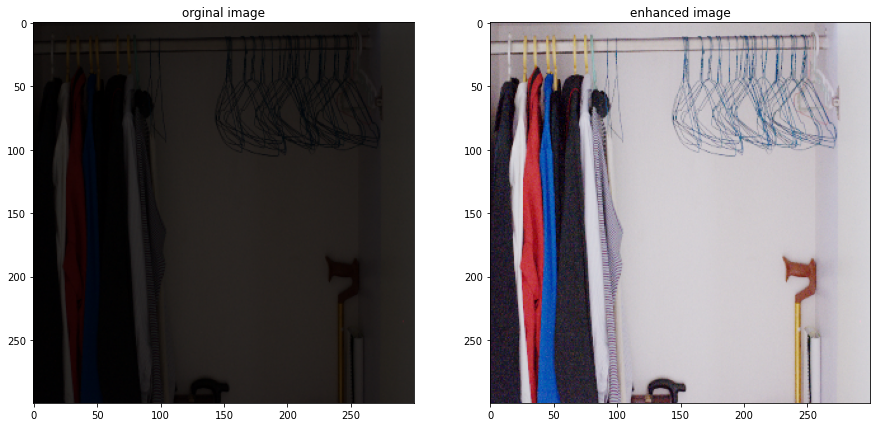

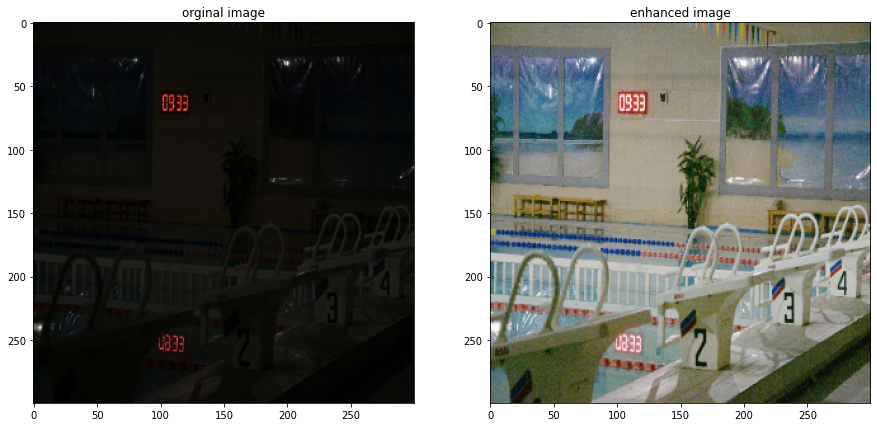

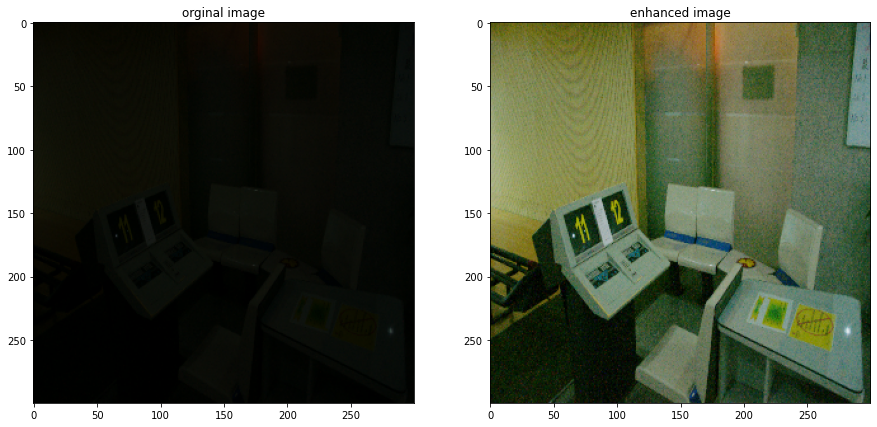

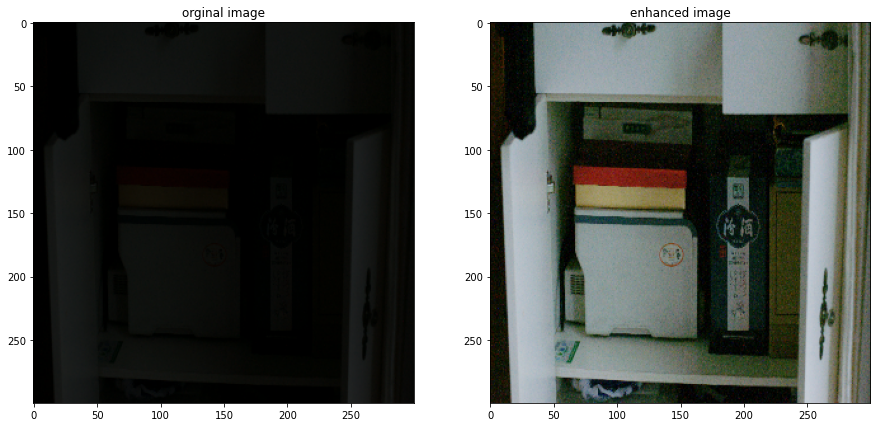

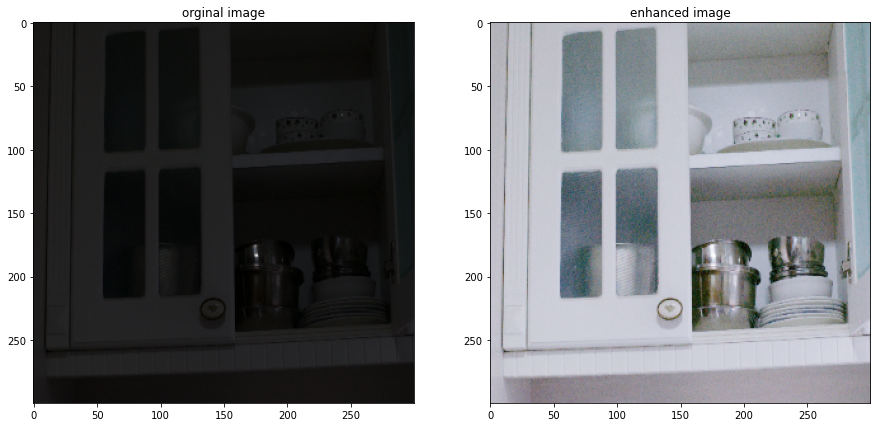

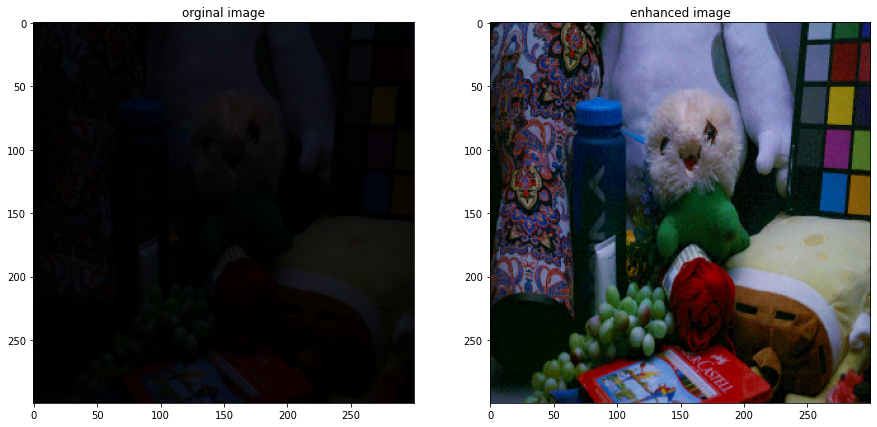

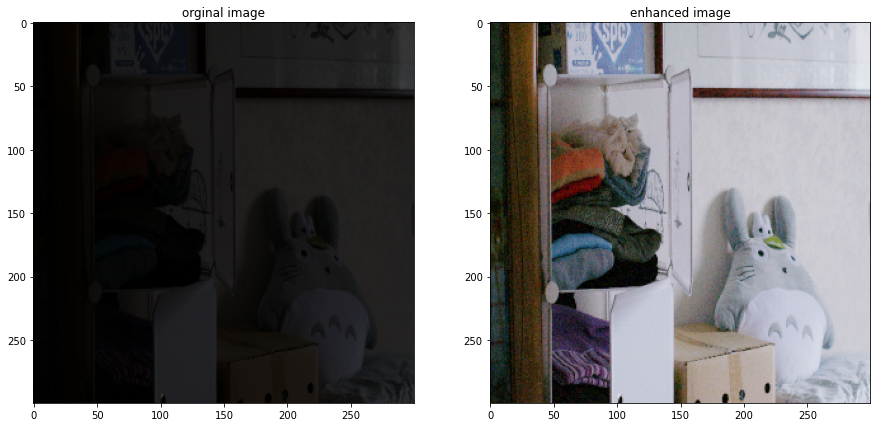

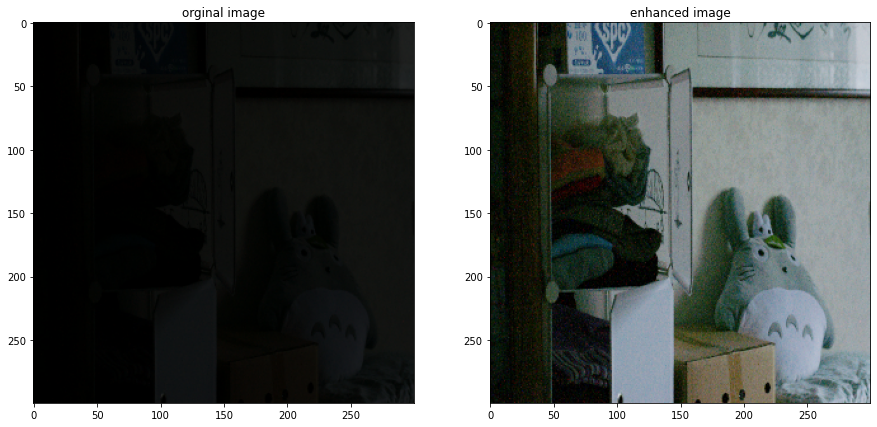

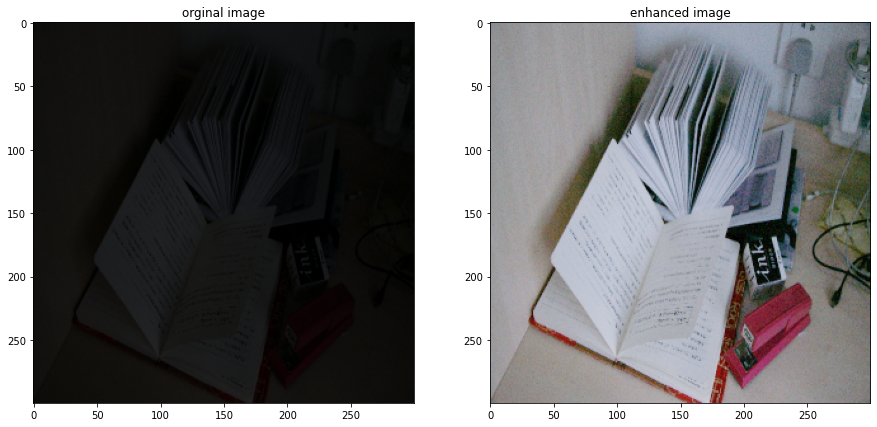

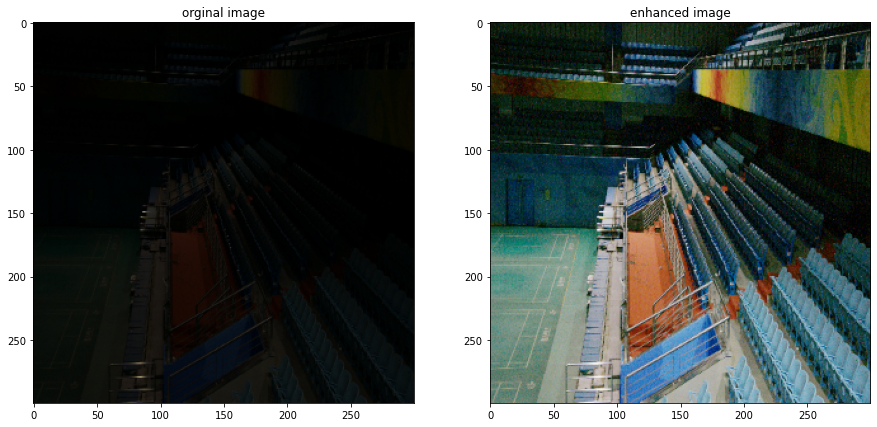

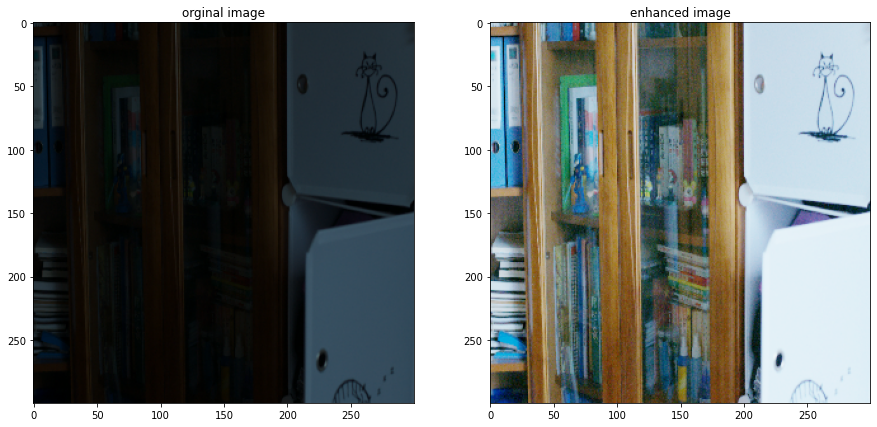

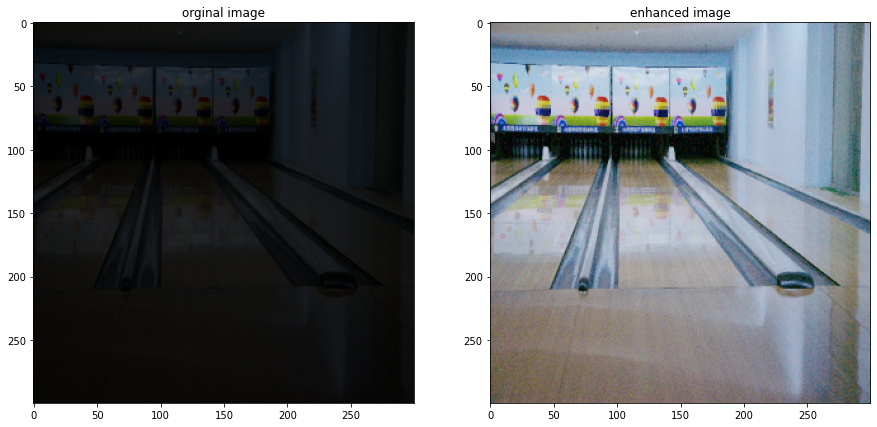

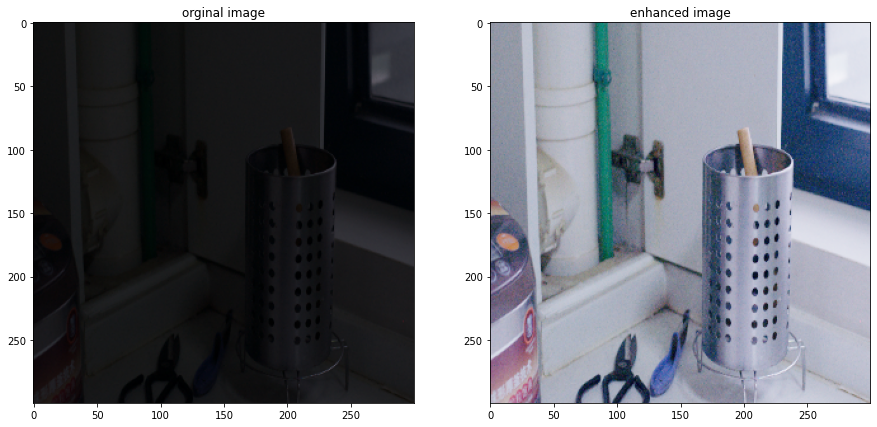

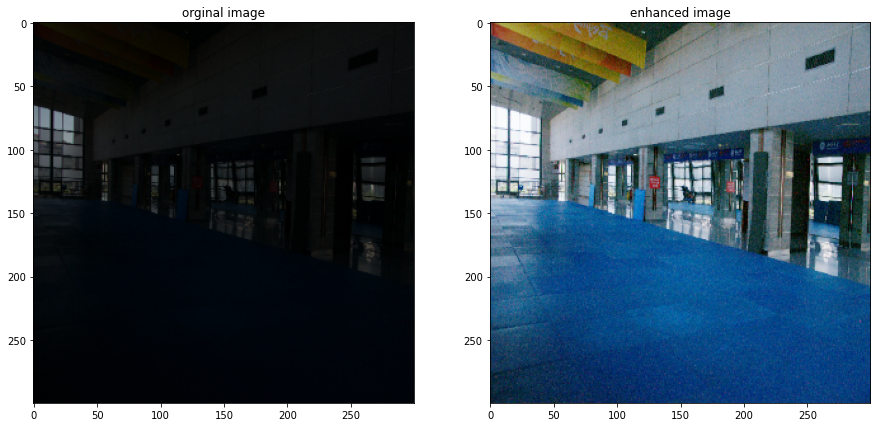

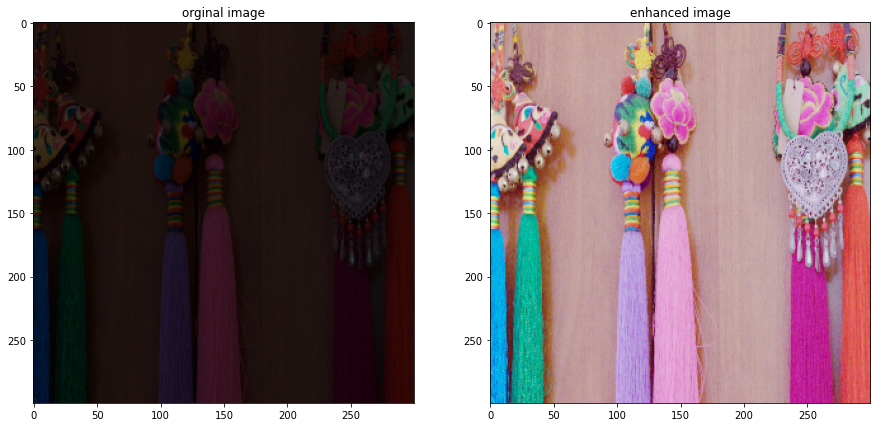

In [23]:
for test_batch in test_images:
  for image in test_batch:
    enhanced_image = zero_dce_model(np.expand_dims(image, axis=0))
    enhanced_image = tf.cast((enhanced_image[0, :, :, :] * 255), dtype=np.uint8)
    image = tf.cast((image[:, :, :] * 255), dtype=np.uint8)
    fig = plt.figure(figsize = (15,8))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title('orginal image')
    ax1.imshow(image)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title('enhanced image')
    ax2.imshow(enhanced_image)
    # plt.imshow(enhanced_image)
    plt.show()
      

In [27]:
m = build_model()

In [33]:
for batch in test_images:
  print(m(np.expand_dims(batch[0], 0)).shape)


(1, 300, 300, 24)


In [ ]:
x = np.array([[[[3, 4, 7], [5, 6, 10]], [[8, 0, 15], [9, 7, 14]]], [[[8, 6, 7], [5, 6, 10]], [[1, 0, 7], [7, 2, 3]]]], dtype='float16')
x.shape

(2, 2, 2, 3)

In [ ]:
x

array([[[[ 3.,  4.,  7.],
         [ 5.,  6., 10.]],

        [[ 8.,  0., 15.],
         [ 9.,  7., 14.]]],


       [[[ 8.,  6.,  7.],
         [ 5.,  6., 10.]],

        [[ 1.,  0.,  7.],
         [ 7.,  2.,  3.]]]], dtype=float16)

In [ ]:
(3 + 8 + 9 + 5) / 4  

6.25

In [ ]:
x[0, :, 1, 2]

array([10., 14.], dtype=float16)

In [ ]:
tf.reduce_mean(x, axis=(1), keepdims=True) ** 2


<tf.Tensor: shape=(2, 1, 2, 3), dtype=float16, numpy=
array([[[[ 30.25,   4.  , 121.  ],
         [ 49.  ,  42.25, 144.  ]]],


       [[[ 20.25,   9.  ,  49.  ],
         [ 36.  ,  16.  ,  42.25]]]], dtype=float16)>

In [ ]:
tf.reduce_mean(x, axis=(1), keepdims=True)

<tf.Tensor: shape=(2, 1, 2, 3), dtype=float16, numpy=
array([[[[ 5.5,  2. , 11. ],
         [ 7. ,  6.5, 12. ]]],


       [[[ 4.5,  3. ,  7. ],
         [ 6. ,  4. ,  6.5]]]], dtype=float16)>

In [ ]:
tf.reduce_mean(x, axis=3, keepdims=True)

<tf.Tensor: shape=(2, 2, 2, 1), dtype=float16, numpy=
array([[[[ 4.668],
         [ 7.   ]],

        [[ 7.668],
         [10.   ]]],


       [[[ 7.   ],
         [ 7.   ]],

        [[ 2.666],
         [ 4.   ]]]], dtype=float16)>

In [ ]:
avgpool = AvgPool2D(pool_size=(2, 2), strides=(1, 1))

In [ ]:
avgpool.call(tf.reduce_mean(x, axis=3, keepdims=True))

<tf.Tensor: shape=(2, 1, 1, 1), dtype=float16, numpy=
array([[[[7.336]]],


       [[[5.168]]]], dtype=float16)>

In [ ]:
(4.668 + 7 + 7.668 + 10) / 4

7.334

In [ ]:
(7 + 7 + 4 + 2.66666) / 4

5.166665

In [ ]:
tf.reduce_mean(x, axis=3, keepdims=True)

<tf.Tensor: shape=(2, 2, 2, 1), dtype=float16, numpy=
array([[[[ 4.668],
         [ 7.   ]],

        [[ 7.668],
         [10.   ]]],


       [[[ 7.   ],
         [ 7.   ]],

        [[ 2.666],
         [ 4.   ]]]], dtype=float16)>

In [ ]:
AvgPool2D(pool_size=(2, 2), strides=[1, 1])(tf.reduce_mean(x, axis=3, keepdims=True))

<tf.Tensor: shape=(2, 1, 1, 1), dtype=float32, numpy=
array([[[[7.3339844]]],


       [[[5.166504 ]]]], dtype=float32)>

In [ ]:
tf.nn.avg_pool2d(tf.reduce_mean(x, axis=3, keepdims=True), 2, 2, 'VALID')

<tf.Tensor: shape=(2, 1, 1, 1), dtype=float16, numpy=
array([[[[7.336]]],


       [[[5.168]]]], dtype=float16)>

In [ ]:
tf.reduce_mean(x, axis=3, keepdims=True).numpy()

array([[[[ 4.668],
         [ 7.   ]],

        [[ 7.668],
         [10.   ]]],


       [[[ 7.   ],
         [ 7.   ]],

        [[ 2.666],
         [ 4.   ]]]], dtype=float16)